In [1]:
# For Google Colab
# from google.colab import files
# print("Upload languageID.tar")
# data_tar_file=[key for key in files.upload().keys()][0]

# !tar -xf $data_tar_file

Upload languageID.tar


Saving languageID.tar to languageID.tar


In [2]:
import os
import numpy as np
import string

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

alpha = 0.5 # Additive smoothing factor
vocab = list(string.ascii_lowercase + ' ')
label_names = {
    'e': 'English',
    'j': 'Japanese',
    's': 'Spanish',
}
label_list = list(label_names.keys())

def load_data(datapath='languageID'):
    x_train = []
    x_test = []
    y_train = []
    y_test = []
    fn_train = []
    fn_test = []
    for filename in os.listdir(datapath):
        id = filename.split('.')[0]
        label = id[0]
        datanum = int(id[1:])
        with open(os.path.join(datapath, filename), 'r') as f:
            doc_string = ''.join(f.readlines()).lower()
            data = [doc_string.count(c) for c in vocab]
        if (datanum < 10):
            x_train.append(data)
            y_train.append(label)
            fn_train.append(filename)
        else:
            x_test.append(data)
            y_test.append(label)
            fn_test.append(filename)
    return [np.array(a) for a in [x_train, x_test, y_train, y_test, fn_train, fn_test]]

def get_prior_probabilities(y_train):
    prior_probs = []
    for label in label_list:
        prior_probs.append(sum(y_train==label))
    prior_probs = np.array(prior_probs) + alpha
    prior_probs = prior_probs/sum(prior_probs)
    return prior_probs

def get_conditional_probabilites(x_train, y_train):
    thetas = []
    for label in label_list:
        N_c_label = np.sum(x_train[y_train==label], axis=0)
        N_c_label_smooth = N_c_label + alpha
        theta = N_c_label_smooth/sum(N_c_label_smooth)
        thetas.append(theta)
    thetas = np.array(thetas)
    return thetas

def get_likelihood_log_probabilities(test_x, trained_conditional_probs):
    likelihood_log_probs_x = np.matmul(np.log10(trained_conditional_probs), test_x)
    return likelihood_log_probs_x

def get_posterior_log_probabilities(test_x, trained_conditional_probs, trained_prior_probs):
    # all calculation is done in log10 to prevent underflow
    # Assumption: log(10^a + 10^b) ~ 10^max(a,b) -> True when x and y are sufficiently far
    likelihood_log_probs_x = get_likelihood_log_probabilities(test_x, trained_conditional_probs)
    posterior_log_probs_x = likelihood_log_probs_x + np.log10(trained_prior_probs) # Exactly: 10^numerator
    posterior_log_probs_x = posterior_log_probs_x - np.max(posterior_log_probs_x) # Approximately: 10^numerator / 10^denominator
    return posterior_log_probs_x

def predict_document(posterior_log_probs_x):
    return label_list[np.argmax(posterior_log_probs_x)]

def predict_documents(x_batch, trained_conditional_probs, trained_prior_probs):
    predictions = []
    for x in x_batch:
        posterior_log_probs_x = get_posterior_log_probabilities(x, trained_conditional_probs, trained_prior_probs)
        predictions.append(predict_document(posterior_log_probs_x))
    predictions = np.array(predictions)
    return predictions




In [3]:
# Q 3 - preprocessing - represent bag-of-character counts
x_train, x_test, y_train, y_test, fn_train, fn_test = load_data()

In [4]:
# Q 3.1
trained_prior_probs = get_prior_probabilities(y_train)
for label, pp in zip(label_list, trained_prior_probs):
    print(f'Prior probability of {label_names[label]} is {pp}')

Prior probability of English is 0.3333333333333333
Prior probability of Japanese is 0.3333333333333333
Prior probability of Spanish is 0.3333333333333333


In [5]:
# Q 3.2 and 3.3
trained_conditional_probs = get_conditional_probabilites(x_train, y_train)
for label, cp in zip(label_list, trained_conditional_probs):
    print(f'Class conditional probability of {label_names[label]} is:\n{cp}')

Class conditional probability of English is:
[0.06016851 0.01113497 0.02151    0.02197258 0.10536924 0.01893276
 0.01747894 0.04721626 0.05541054 0.00142078 0.00373369 0.02897737
 0.02051875 0.05792169 0.0644639  0.01675202 0.0005617  0.05382455
 0.06618206 0.08012556 0.02666446 0.00928465 0.01549645 0.00115645
 0.01384437 0.00062779 0.17924996]
Class conditional probability of Japanese is:
[1.31765610e-01 1.08669066e-02 5.48586603e-03 1.72263182e-02
 6.02047591e-02 3.87854223e-03 1.40116706e-02 3.17621161e-02
 9.70334393e-02 2.34110207e-03 5.74094133e-02 1.43261470e-03
 3.97987351e-02 5.67105769e-02 9.11632132e-02 8.73545547e-04
 1.04825466e-04 4.28037318e-02 4.21747790e-02 5.69901115e-02
 7.06174220e-02 2.44592753e-04 1.97421294e-02 3.49418219e-05
 1.41514379e-02 7.72214263e-03 1.23449457e-01]
Class conditional probability of Spanish is:
[1.04560451e-01 8.23286362e-03 3.75258241e-02 3.97459221e-02
 1.13810860e-01 8.60287996e-03 7.18448398e-03 4.53270019e-03
 4.98597021e-02 6.62945947

In [6]:
# Q 3.4
# Format is a,b,...,z,<space>
fname = 'e10.txt'
test_x = x_test[fn_test==fname][0]
print(f'Bag-of-characters representation of {fname}:\n{test_x}')

Bag-of-characters representation of e10.txt:
[164  32  53  57 311  55  51 140 140   3   6  85  64 139 182  53   3 141
 186 225  65  31  47   4  38   2 498]


In [7]:
# Q 3.5
likelihood_log_probs_x = get_likelihood_log_probabilities(test_x, trained_conditional_probs)

for label, llp in zip(label_list, likelihood_log_probs_x):
    print(f'Likelihood log probability of {label_names[label]} is: {llp}')

Likelihood log probability of English is: -3405.678891486211
Likelihood log probability of Japanese is: -3809.384984625936
Likelihood log probability of Spanish is: -3677.293868432272


In [8]:
# Q 3.6
posterior_log_probs_x = get_posterior_log_probabilities(test_x, trained_conditional_probs, trained_prior_probs)

for label, plp in zip(label_list, posterior_log_probs_x):
    print(f'Posterior log probability of {label_names[label]} is: {plp}')
prediction_label_x = predict_document(posterior_log_probs_x)
print(f'Prediction of {fname} is {label_names[prediction_label_x]}')

Posterior log probability of English is: 0.0
Posterior log probability of Japanese is: -403.706093139725
Posterior log probability of Spanish is: -271.61497694606123
Prediction of e10.txt is English


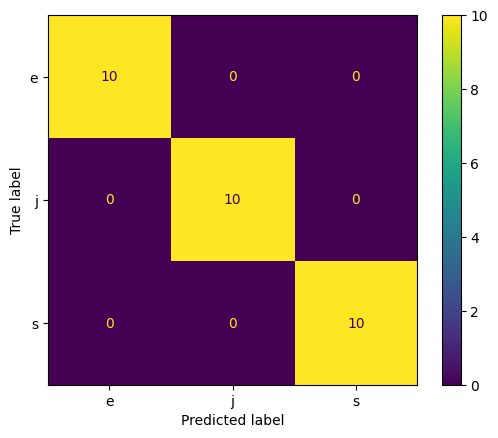

In [9]:
# Q 3.7
y_preds = predict_documents(x_test, trained_conditional_probs, trained_prior_probs)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_preds, labels=label_list), display_labels=label_list).plot()

In [1]:
import torch
import torch.nn.functional as F
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import v2 as transforms

transform=transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.1307,], std=[0.3081,]),
])
train_val_dataset = datasets.MNIST('../data', train=True, download=True)
test_dataset = datasets.MNIST('../data', train=False)
x_train, x_val, y_train, y_val = train_test_split(train_val_dataset.data, train_val_dataset.targets, test_size=len(test_dataset), random_state=42)
x_test, y_test = test_dataset.data, test_dataset.targets
x_train = transform(x_train)
x_val = transform(x_val)
x_test = transform(x_test)

100%|██████████| 9912422/9912422 [00:00<00:00, 75194491.76it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30466723.80it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22021134.37it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13987172.37it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [8]:
# Matrix pretty print
# Enhanced upon reference: https://stackoverflow.com/a/13214945
def fmt_matrix(matrix, header_row = False):
    s = [[str(e) for e in row] for row in matrix]
    lens = [max(map(len, col)) for col in zip(*s)]
    fmt = ''.join('| {{:{}}} '.format(x) for x in lens) + '|'
    sep_row = lambda c, sep = '|': sep.join([''] + [c*(l+2) for l in lens] + [''])
    table = [fmt.format(*row) for row in s]
    if (header_row):
        table.insert(1, sep_row('—'))
    return '\n'.join(table)

def run_hyperparameter_analysis(ModelClass, weight_inits = ['zeros', 'randmod1'], batch_sizes = [32,64]):
    results = {}
    for wi in weight_inits:
        results[wi] = {}
        for bs in batch_sizes:
            model = ModelClass(weight_init=wi)
            model.fit(x_train, y_train, x_val, y_val, batch_size=bs, epochs=100, learning_rate=0.01, early_stop_epochs=10, print_logs=False)
            test_accuracy = model.predict_accuracy(x_test, y_test)
            results[wi][bs] = test_accuracy
            # print(f'Model with initialization: "{wi}" \tbatch size: {bs}\tTest accuracy: {test_accuracy:.6f}')
    return results

def print_results(results):
    mat = [['Weight Initialization', 'Batch size', 'Test accuracy']]
    for wi in results:
        for bs in results[wi]:
            mat.append([wi, bs, results[wi][bs]])
    print(fmt_matrix(mat, header_row=True))

def run_learning_curve_analysis(ModelClass, weight_init = 'randmod1', epochs = 100, learning_rate=0.01, batch_size = 64, early_stop_epochs=10):
    # Learning curve analysis of ModelClass
    training_data_sizes = []
    train_accuracies = []
    test_accuracies = []
    for i in range(5):
        # train_subset_length = len(x_train)//(2**i)
        train_subset_length = 10000*(i+1)
        x_train_subset = x_train[:train_subset_length]
        y_train_subset = y_train[:train_subset_length]
        model = ModelClass(weight_init=weight_init)
        model.fit(x_train_subset, y_train_subset, x_val, y_val, batch_size=batch_size, epochs=epochs, learning_rate=learning_rate, early_stop_epochs=early_stop_epochs, print_logs=False)
        train_accuracy = model.predict_accuracy(x_train_subset, y_train_subset)
        test_accuracy = model.predict_accuracy(x_test, y_test)
        training_data_sizes.append(train_subset_length)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    plt.plot(training_data_sizes, train_accuracies, marker='o', label='Train score')
    plt.plot(training_data_sizes, test_accuracies, marker='o', label='Test score')
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning curve for {ModelClass.__name__}')

    plt.show()
    return training_data_sizes, train_accuracies, test_accuracies

In [4]:
class SelfModel():
    def __init__(self, weight_init = 'zeros'):
        if (weight_init == 'zeros'):
            self.weights_w1 = torch.zeros(28*28, 300)
            self.weights_w2 = torch.zeros(300, 10)
        elif (weight_init == 'randmod1'):
            self.weights_w1 = (torch.rand(28*28, 300) - 0.5) * 2
            self.weights_w2 = (torch.rand(300, 10) - 0.5) * 2
        elif (weight_init == 'randmod.5'):
            self.weights_w1 = torch.rand(28*28, 300) - 0.5
            self.weights_w2 = torch.rand(300, 10) - 0.5
        elif (weight_init == 'randmod.1'):
            self.weights_w1 = (torch.rand(28*28, 300) - 0.5) * 0.2
            self.weights_w2 = (torch.rand(300, 10) - 0.5) * 0.2

    def _reshape_inputs(self, x, y):
        if x is not None:
            x = torch.flatten(x, start_dim=1)
        if y is not None:
            y = F.one_hot(y)
        return x, y

    def _generate_batches(self, x, y, batch_size):
        batches = []
        start_index = 0
        while(start_index < len(x)):
            batches.append((x[start_index:start_index+batch_size], y[start_index:start_index+batch_size]))
            start_index += batch_size
        return batches

    def _forward_pass(self, x):
        a1 = torch.matmul(x, self.weights_w1)
        z1 = torch.sigmoid(a1)
        a2 = torch.matmul(z1, self.weights_w2)
        y_probs = torch.softmax(a2, dim=1)
        return a1, z1, a2, y_probs

    def fit(self, x_train, y_train, x_val, y_val, batch_size = 64, epochs=10, learning_rate = 0.001, early_stop_epochs = None, print_logs=True):
        x_train, y_train = self._reshape_inputs(x_train, y_train)
        batches = self._generate_batches(x_train, y_train, batch_size)

        if early_stop_epochs is None:
            early_stop_epochs = epochs

        # Storing best results
        best_epoch, best_acc, best_weights = (-1, 0.0, None)
        for epoch in range(epochs):
            for batch_idx, (x, y) in enumerate(batches):
                # Forward pass
                a1, z1, a2, y_probs = self._forward_pass(x)

                # Compute loss
                loss = -torch.sum(torch.log(y_probs) * y)/len(y)

                # Compute gradients
                grad_a2 = y_probs - y
                grad_w2 = torch.matmul(z1.T, grad_a2)
                grad_z1 = torch.matmul(grad_a2, self.weights_w2.T)
                grad_w1 = torch.matmul(x.T, grad_z1*z1*(1-z1))

                # Update weights
                self.weights_w2 -= learning_rate*grad_w2
                self.weights_w1 -= learning_rate*grad_w1

            val_acc = self.predict_accuracy(x_val, y_val)
            if print_logs:
                print('Train Epoch: {} \tLoss: {:.6f} \tValAccuracy: {:.6f}'.format(epoch, loss, val_acc))
            if (val_acc > best_acc):
                best_epoch, best_acc, best_weights = epoch, val_acc, (self.weights_w1, self.weights_w2)
            if (epoch - best_epoch > early_stop_epochs):
                if print_logs:
                    print(f'Early stopping after {epoch} epochs')
                break

        # Restoring best results
        if print_logs:
            print(f'Restoring best results from epoch:{best_epoch} with ValAccuracy: {best_acc:.4f}')
        self.weights_w1, self.weights_w2 = best_weights

    def predict_prob(self, x):
        x, _ = self._reshape_inputs(x, None)
        a1, z1, a2, y_probs = self._forward_pass(x)
        return y_probs

    def predict(self, x):
        y_probs = self.predict_prob(x)
        return torch.argmax(y_probs, dim=1)

    def predict_accuracy(self, x, y):
        y_pred = self.predict(x)
        return sum(torch.eq(y_pred, y).tolist())/len(y)



Analysis for SelfModel
| Weight Initialization | Batch size | Test accuracy |
|———————————————————————|————————————|———————————————|
| zeros                 | 32         | 0.4443        |
| zeros                 | 64         | 0.3984        |
| randmod1              | 32         | 0.9536        |
| randmod1              | 64         | 0.9504        |
Learning Curve with randmod1 initialization


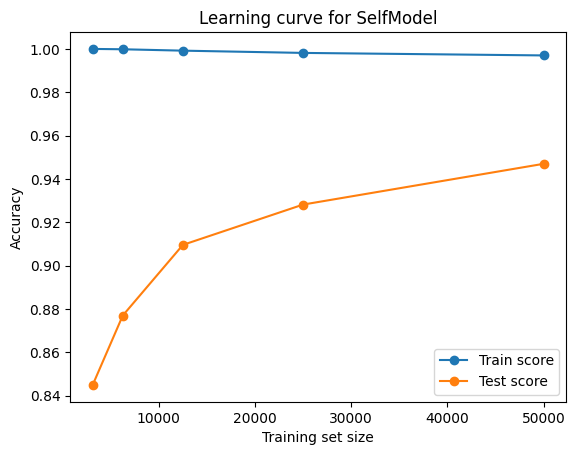

([50000, 25000, 12500, 6250, 3125],
 [0.997, 0.99816, 0.9992, 0.99984, 1.0],
 [0.947, 0.9282, 0.9096, 0.877, 0.845])

In [19]:
# 4.2 - results
sm_results = run_hyperparameter_analysis(SelfModel)
print('Analysis for SelfModel')
print_results(sm_results)
print('Learning Curve with randmod1 initialization')
run_learning_curve_analysis(SelfModel, epochs=10)

In [5]:
# 4.3 - Implementation
class TorchModel(torch.nn.Module):
    def __init__(self, weight_init = 'zeros'):
        super(TorchModel, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 300)
        self.fc2 = torch.nn.Linear(300, 10)

        def init_weights(layer):
            if isinstance(layer, torch.nn.Linear):
                if (weight_init == 'zeros'):
                    torch.nn.init.constant_(layer.weight, 0)
                    torch.nn.init.constant_(layer.weight, 0)
                elif (weight_init == 'randmod1'):
                    torch.nn.init.uniform_(layer.weight, -1, 1)
                    torch.nn.init.uniform_(layer.weight, -1, 1)
                elif (weight_init == 'randmod.5'):
                    torch.nn.init.uniform_(layer.weight, -0.5, 0.5)
                    torch.nn.init.uniform_(layer.weight, -0.5, 0.5)
        self.apply(init_weights)

    def _generate_batches(self, x, y, batch_size):
        batches = []
        start_index = 0
        while(start_index < len(x)):
            batches.append((x[start_index:start_index+batch_size], y[start_index:start_index+batch_size]))
            start_index += batch_size
        return batches

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x # F.cross_entropy loss internally calculates softmax

    def fit(self, x_train, y_train, x_val, y_val, batch_size = 64, epochs=10, learning_rate = 0.001, early_stop_epochs = None, print_logs=True):
        batches = self._generate_batches(x_train, y_train, batch_size)

        if early_stop_epochs is None:
            early_stop_epochs = epochs

        optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        # Storing best results
        best_epoch, best_acc, best_weights = (-1, 0.0, None)
        for epoch in range(epochs):
            self.train()
            for batch_idx, (x, y) in enumerate(batches):
                optimizer.zero_grad()
                logits = self(x)
                loss = F.cross_entropy(logits, y)
                loss.backward()
                optimizer.step()

            val_acc = self.predict_accuracy(x_val, y_val)
            if print_logs:
                print('Train Epoch: {} \tLoss: {:.6f} \tValAccuracy: {:.6f}'.format(epoch, loss, val_acc))
            if (val_acc > best_acc):
                best_epoch, best_acc, best_weights = epoch, val_acc, deepcopy(self.state_dict())
            if (epoch - best_epoch > early_stop_epochs):
                if print_logs:
                    print(f'Early stopping after {epoch} epochs')
                break

        # Restoring best results
        if print_logs:
            print(f'Restoring best results from epoch:{best_epoch} with ValAccuracy: {best_acc:.4f}')
        self.load_state_dict(best_weights)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self(x)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        return pred

    def predict_accuracy(self, x, y):
        pred = self.predict(x)
        correct = pred.eq(y.view_as(pred)).sum().item()
        return correct/len(y)



Analysis for TorchModel
| Weight Initialization | Batch size | Test accuracy |
|———————————————————————|————————————|———————————————|
| zeros                 | 32         | 0.9723        |
| zeros                 | 64         | 0.9606        |
| randmod1              | 32         | 0.9274        |
| randmod1              | 64         | 0.9204        |
Learning Curve with randmod1 initialization


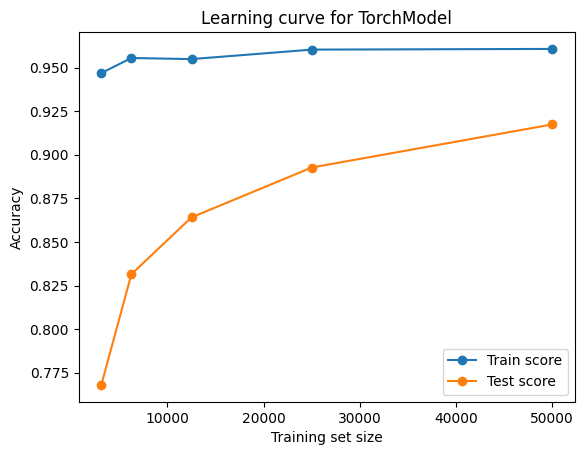

([50000, 25000, 12500, 6250, 3125],
 [0.96072, 0.96032, 0.95488, 0.95552, 0.94688],
 [0.9174, 0.8927, 0.8641, 0.8315, 0.768])

In [6]:
# 4.3 - results
tm_results = run_hyperparameter_analysis(TorchModel)
print('Analysis for TorchModel')
print_results(tm_results)
print('Learning Curve with randmod1 initialization')
run_learning_curve_analysis(TorchModel)

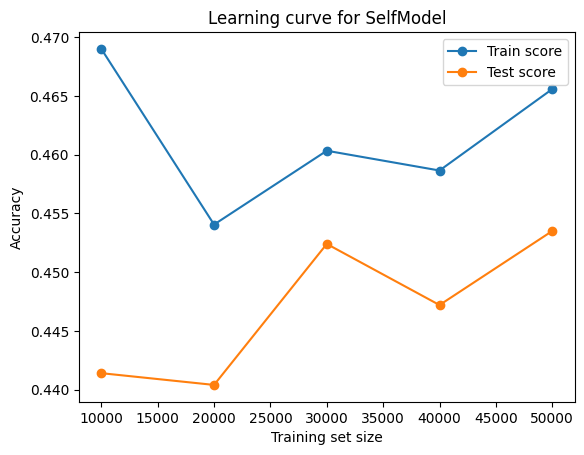

([10000, 20000, 30000, 40000, 50000],
 [0.469, 0.45405, 0.4603333333333333, 0.45865, 0.46558],
 [0.4414, 0.4404, 0.4524, 0.4472, 0.4535])

In [9]:
# 4.4 Comparing learning curve with 'zeros' weight initialization
print('Learning Curve with zeros initialization')
run_learning_curve_analysis(SelfModel, weight_init='zeros', epochs=50, early_stop_epochs=None, learning_rate=0.005, batch_size=16)

In [29]:
# Saving results from hyperparameter experiments:
#
# Model with initialization: "zeros" 	    hidden layer size: 300 	batch size: 32	Test accuracy: 0.444300
# Model with initialization: "zeros" 	    hidden layer size: 300 	batch size: 64	Test accuracy: 0.398400
# Model with initialization: "zeros" 	    hidden layer size: 300 	batch size: 128	Test accuracy: 0.393900
# Model with initialization: "zeros" 	    hidden layer size: 200 	batch size: 32	Test accuracy: 0.639700
# Model with initialization: "zeros" 	    hidden layer size: 200 	batch size: 64	Test accuracy: 0.561500
# Model with initialization: "zeros" 	    hidden layer size: 200 	batch size: 128	Test accuracy: 0.717900
# Model with initialization: "zeros" 	    hidden layer size: 500 	batch size: 32	Test accuracy: 0.751500
# Model with initialization: "zeros" 	    hidden layer size: 500 	batch size: 64	Test accuracy: 0.603800
# Model with initialization: "zeros" 	    hidden layer size: 500 	batch size: 128	Test accuracy: 0.575800
# Model with initialization: "randmod1" 	hidden layer size: 300 	batch size: 32	Test accuracy: 0.957600
# Model with initialization: "randmod1" 	hidden layer size: 300 	batch size: 64	Test accuracy: 0.952700
# Model with initialization: "randmod1" 	hidden layer size: 300 	batch size: 128	Test accuracy: 0.954400
# Model with initialization: "randmod1" 	hidden layer size: 200 	batch size: 32	Test accuracy: 0.952800
# Model with initialization: "randmod1" 	hidden layer size: 200 	batch size: 64	Test accuracy: 0.953200
# Model with initialization: "randmod1" 	hidden layer size: 200 	batch size: 128	Test accuracy: 0.950400
# Model with initialization: "randmod1" 	hidden layer size: 500 	batch size: 32	Test accuracy: 0.953300
# Model with initialization: "randmod1" 	hidden layer size: 500 	batch size: 64	Test accuracy: 0.955400
# Model with initialization: "randmod1" 	hidden layer size: 500 	batch size: 128	Test accuracy: 0.955600
# Model with initialization: "randmod.5" 	hidden layer size: 300 	batch size: 32	Test accuracy: 0.968500
# Model with initialization: "randmod.5" 	hidden layer size: 300 	batch size: 64	Test accuracy: 0.971800
# Model with initialization: "randmod.5" 	hidden layer size: 300 	batch size: 128	Test accuracy: 0.971300
# Model with initialization: "randmod.5" 	hidden layer size: 200 	batch size: 32	Test accuracy: 0.968500
# Model with initialization: "randmod.5" 	hidden layer size: 200 	batch size: 64	Test accuracy: 0.968400
# Model with initialization: "randmod.5" 	hidden layer size: 200 	batch size: 128	Test accuracy: 0.970500
# Model with initialization: "randmod.5" 	hidden layer size: 500 	batch size: 32	Test accuracy: 0.969100
# Model with initialization: "randmod.5" 	hidden layer size: 500 	batch size: 64	Test accuracy: 0.970800
# Model with initialization: "randmod.5" 	hidden layer size: 500 	batch size: 128	Test accuracy: 0.972800